##REDES NEURONALES

Proyecto 1.

#### Modelo de prediccion del cierre de las acciones de APPLE.

Datos obtenidos de NASDAQ, periodo 2015-2025.


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [3]:
#Cargar datos de entrenamiento
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [23]:
df = pd.read_csv('/content/drive/MyDrive/apple_stock 2015-2024.csv')


In [24]:
# Eliminar el símbolo de dólar y convertir a float
df["Close/Last"] = df["Close/Last"].str.replace("$", "").astype(float)
df["Open"] = df["Open"].str.replace("$", "").astype(float)
df["High"] = df["High"].str.replace("$", "").astype(float)
df["Low"] = df["Low"].str.replace("$", "").astype(float)

# Convertir la fecha y ordenar
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

df.head()

,Date,Close/Last,Volume,Open,High,Low
2451,2015-04-07,31.50,139579240,31.91,32.03,31.50
2450,2015-04-08,31.40,149088360,31.46,31.60,31.24
2449,2015-04-09,31.64,128977440,31.46,31.65,31.17
2448,2015-04-10,31.78,160503040,31.49,31.80,31.32
2447,2015-04-13,31.71,144994480,32.09,32.14,31.65


In [25]:
df.isna().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


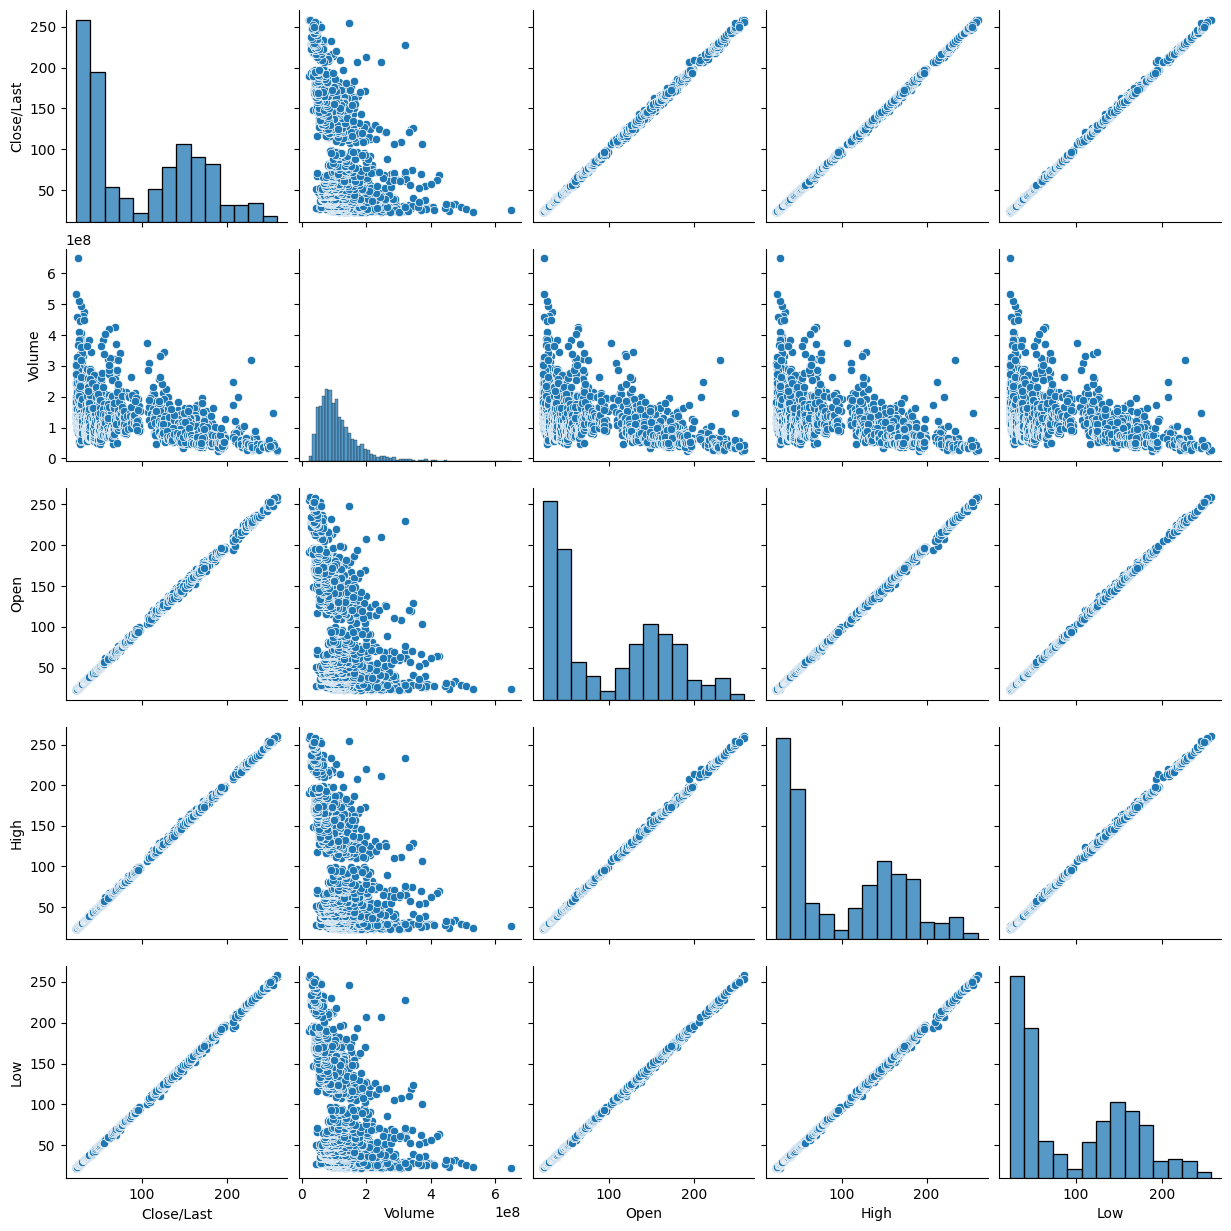

In [7]:
sns.pairplot(df)

In [8]:
X = df[['Volume', 'Open', 'Low', 'High']]  # Variables independientes
y = df['Close/Last']  # Variable objetivo

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [9]:
#Escalado de datos

scaler = MinMaxScaler(feature_range=(0,1))  #tranformar los datos en 0 y 1 para la convergencia del modelo

df_features = df[['Close/Last', 'Volume', 'Open', 'Low', 'High']]
train_scaled = scaler.fit_transform(df_features) #calculamos los min y max

#cear secuencias temporales, datos para el crecimiento
def create_dataset(dataset, look_back=30):  #se utilizó un look_back =30, indica que se tomarán los 30 dias previos para predecir el siguiente valor
  X,Y = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+ look_back), :]
    X.append(a)
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 30)


In [10]:
print(X_train.shape)
print(y_train.shape)


(2422, 30, 5)
(2422,)


Se utilizará el optimizador ADAM con una tasa de aprendizaje del 0.001 por su efectividad en problemas de optimización no convexos y por su capacidad para ajustar automáticamente el ritmo de aprendizaje y mejorar el rendimiento general del modelo.

In [11]:
#Modelo LSTM
model = Sequential([
    LSTM(100, input_shape =(X_train.shape[1], X_train.shape[2]), return_sequences = True), #devuelve salidas para cada paso y apila
    Dropout(0.2), #evitar el sobreajuste, apaga aleatoriemente el 20% de las neuronas del entrenamiento
    LSTM(100, return_sequences = False), #segunda capa, false ya que asi nos da el resultado final y no toda la secuencia
    Dense(1) #capa final, nos da una neurona que predice el siguiente valor
])

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')  #compilamos el modelo, con el optimizador 'Adam' junto con su tasa de aprendizaje

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size = 32, verbose=1)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0168
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 5.9992e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.3086e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 4.6421e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 5.0121e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 4.3367e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 3.9735e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4.1986e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.6977e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 3.8778e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.8077e-04
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.4882e-04
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3.6622e-04
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 3.4860e-04
Epoch 15/50
76/76 ━

In [40]:
real_data =  pd.read_csv('/content/drive/MyDrive/apple_stock2025.csv')



In [41]:
#Eliminar el símbolo de dólar y convertir a float
real_data["Close/Last"] = real_data["Close/Last"].str.replace("$", "").astype(float)
real_data["Open"] = real_data["Open"].str.replace("$", "").astype(float)
real_data["High"] = real_data["High"].str.replace("$", "").astype(float)
real_data["Low"] = real_data["Low"].str.replace("$", "").astype(float)

# Convertir la fecha y ordenar
real_data["Date"] = pd.to_datetime(real_data["Date"])
real_data = real_data.sort_values("Date")

real_data.head()

,Date,Close/Last,Volume,Open,High,Low
64,2025-01-02,243.85,55740730,248.93,249.10,241.82
63,2025-01-03,243.36,40244110,243.36,244.18,241.89
62,2025-01-06,245.00,45045570,244.31,247.33,243.20
61,2025-01-07,242.21,40855960,242.98,245.55,241.35
60,2025-01-08,242.70,37628940,241.92,243.71,240.05


In [42]:
features = ['Close/Last', 'Volume', 'Open', 'Low', 'High']
real_scaled = scaler.transform(real_data[features])

In [16]:
#Crear datos de entrada para prediccion
X_real, _ = create_dataset(np.vstack([train_scaled[-30:], real_scaled]), look_back=30) #los ultimos 60 datos de entrenamiento los toma en cuenta


#Predicciones
prediction_scaled= model.predict(X_real)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


In [17]:
# Rellenar las otras columnas con ceros solo para invertir el escalado
pad = np.zeros((len(prediction_scaled), len(features) - 1))  # 4 columnas de relleno
predictions_full = np.concatenate([prediction_scaled, pad], axis=1)

# Invertir escalado
predictions = scaler.inverse_transform(predictions_full)[:, 0]  # Solo nos interesa 'Close/Last'


real_prices = real_data['Close/Last'].values


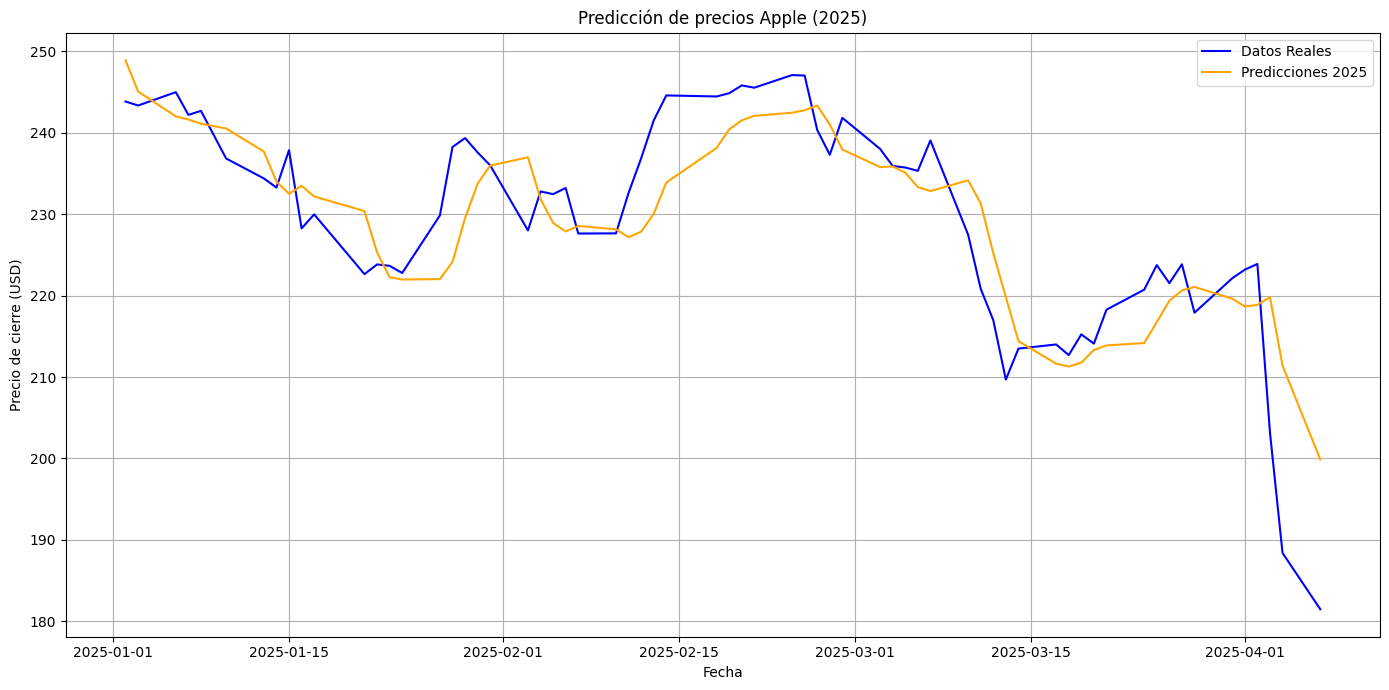

In [18]:
plt.figure(figsize=(14,7))
plt.plot(real_data["Date"], real_prices, label='Datos Reales', color='blue')
plt.plot(real_data["Date"][:len(predictions)], predictions, label='Predicciones 2025', color='orange')
plt.title('Predicción de precios Apple (2025)')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Se puede observar en la gráfica que si bien el modelo sigue bien la forma general del precio, lo que indica que sí aprendió del patrón histórico, especialmente en los dos primeros meses.

Las últimas predicciones se van muy por encima de los datos reales, lo que puede significar que el modelo no está captando los cambios bruscos recientes.

In [39]:
# DataFrame comparativo
results_df = pd.DataFrame({
    'Fecha': real_data['Date'].values[:len(predictions)],
    'Precio Real': real_prices[:len(predictions)],
    'Precio Predicho': predictions
})

# Redondearresults_df = results_df.round(2)

# Mostrar primeras filas
print(results_df.head())


        Fecha  Precio Real  Precio Predicho
0  2025-01-02       243.85           248.92
1  2025-01-03       243.36           245.08
2  2025-01-06       245.00           242.03
3  2025-01-07       242.21           241.64
4  2025-01-08       242.70           241.12
5  2025-01-10       236.85           240.54
6  2025-01-13       234.40           237.70
7  2025-01-14       233.28           234.02
8  2025-01-15       237.87           232.51
9  2025-01-16       228.26           233.49
10 2025-01-17       229.98           232.19
11 2025-01-21       222.64           230.39
12 2025-01-22       223.83           225.33
13 2025-01-23       223.66           222.26
14 2025-01-24       222.78           221.98
15 2025-01-27       229.86           222.03
16 2025-01-28       238.26           224.14
17 2025-01-29       239.36           229.53
18 2025-01-30       237.59           233.76
19 2025-01-31       236.00           235.98
20 2025-02-03       228.01           237.00
21 2025-02-04       232.80      